# Upscaling for a conductive sphere


In [1]:
import numpy as np
import os
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import(
    maps, Report, data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)
from pymatsolver import Pardiso

from utils import pad_for_casing_and_data

In [2]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [3]:
directory_path = "/t40array/lheagy/casing-upscaling-sphere-conductivity"

In [4]:
def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")

# Example usage
ensure_directory_exists(directory_path)

Directory '/t40array/lheagy/casing-upscaling-sphere-conductivity' already exists.


In [5]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [6]:
# # conductivities
sigma_air = 1e-4
sigma_back = 1e-1
casing_l = 500
sigma_casing = np.r_[5e5, 1e6, 5e6, 1e7]
mur_casing = np.r_[1]

# # casing geometry
casing_b = 0.5 #10e-2  
casing_t = 0.1 #2e-2 #np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = casing_b - casing_t

In [7]:
src_dz = 1
src_z = -2 #np.r_[-100, -250, -400, -495, -500, -550, -600]

In [8]:
# generate a mesh
hx = pad_for_casing_and_data(
   casing_outer_radius = casing_b,
    csx1 = casing_t/4, 
    csx2 = 25, 
    pfx1 = 1.3,
    pfx2 = 1.5, 
    domain_x = 100, 
    npadx = 10
)

hz = np.r_[np.flipud(hx), hx]
# pfz = 1.3
# npad_z = 28
# csz = 1
# n_core_extra = 10
# ncore_z = int(np.max(np.r_[np.abs(casing_l), np.abs(src_z)]) / csz) + n_core_extra
# hz = discretize.utils.unpack_widths(
#     [(csz, npad_z, -pfz), (csz, ncore_z), (csz, npad_z, pfz)]
# )

In [9]:
hx.min()

0.02437431876904624

In [10]:
hz.min()

0.02437431876904624

(-4867.36572265625, 4867.36572265625)

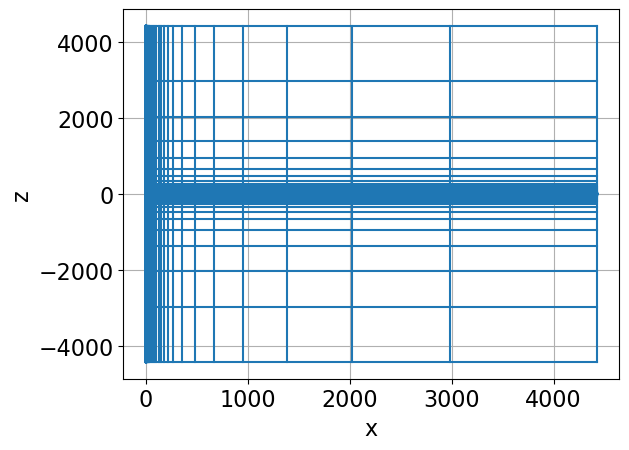

In [11]:
mesh = discretize.CylindricalMesh(
    [hx, np.r_[2*np.pi], hz], origin="00C",
)

lim = None #0.5*np.r_[-1, 1]
fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)
ax.set_xlim(lim)
ax.set_ylim(lim)
# ax.set_ylim(-50, 10)

In [12]:
mesh.n_cells

7688

In [13]:
def get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back, sigma_casing, sigma_air=1e-4, mur_casing=1):

    model = np.ones(mesh.n_cells) * sigma_back

    mur = np.ones(mesh.n_cells)

    inds_casing = (
        ((mesh.cell_centers[:, 0]**2 + mesh.cell_centers[:, 2]**2) > casing_a**2) &
        ((mesh.cell_centers[:, 0]**2 + mesh.cell_centers[:, 2]**2) <= casing_b**2)
    )
        
    model[inds_casing] = sigma_casing
    mur[inds_casing] = mur_casing

    return model, mur

    

In [14]:
sigma_back

0.1

In [15]:
models = {}
for sig in sigma_casing:
    for mur in mur_casing:
        key = f"casing_sig{sig:1.0e}_mur{mur:1.0f}"
        sig_model, mur_model = get_physical_property_model(mesh, casing_a, casing_b, casing_l, sigma_back, sig)
        models[key] = {
            "sigma": sig_model, 
            "mur": mur_model
        }
keys = list(models.keys())

In [16]:
keys

['casing_sig5e+05_mur1',
 'casing_sig1e+06_mur1',
 'casing_sig5e+06_mur1',
 'casing_sig1e+07_mur1']

In [17]:
def plot_casing(model, xlim=None, zlim=None, vmin=None, vmax=None, ax=None, cb_label=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 1)
    pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
    out = mesh.plot_image(
        model, pcolor_opts=pcolor_opts, ax=ax, mirror=True
    )

    cb = plt.colorbar(out[-1])
    cb.set_label(cb_label)

    if xlim is not None: 
        ax.set_xlim(xlim)
    if zlim is not None: 
        ax.set_ylim(zlim)

    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

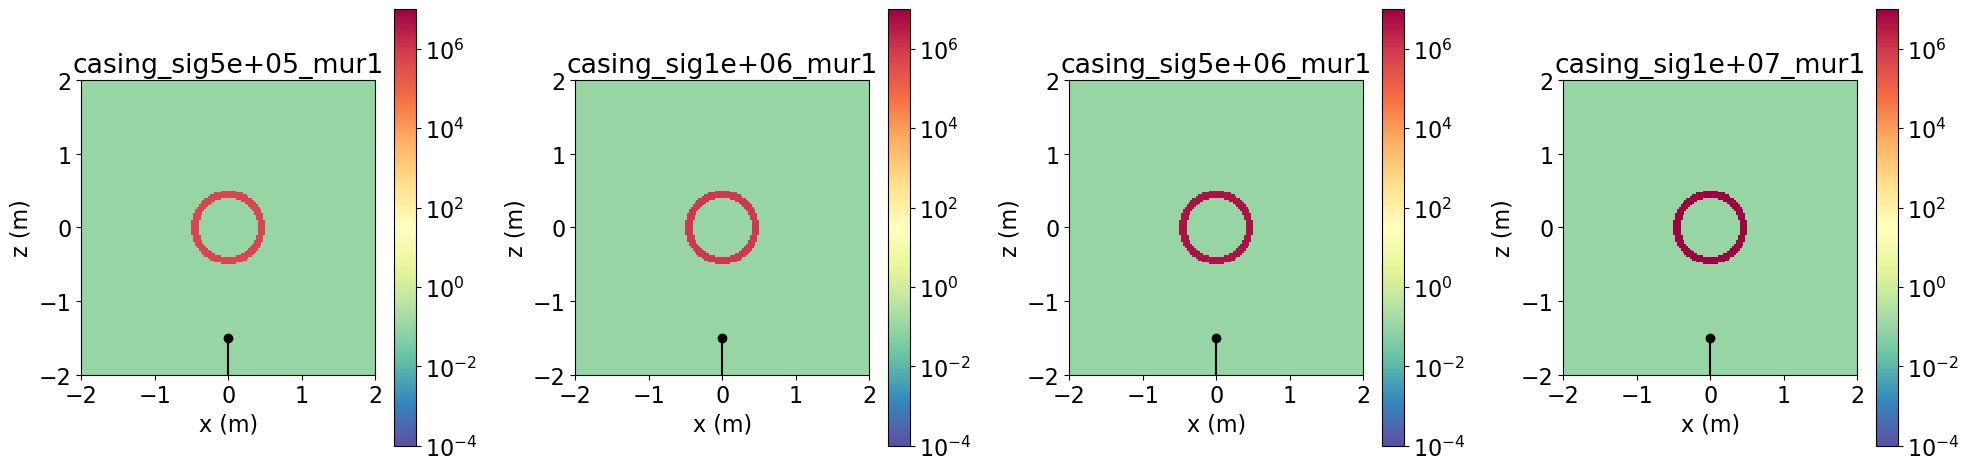

In [18]:
plot_keys = keys
fig, ax = plt.subplots(1, len(plot_keys), figsize=(5*len(plot_keys), 5))

xlim = 2*np.r_[-1, 1]
zlim = xlim
vmin = sigma_air
vmax = np.max(sigma_casing)

for i, key in enumerate(plot_keys):
    plot_casing(models[key]["sigma"], xlim=xlim, zlim=zlim, vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(key)
    ax[i].plot(np.r_[0, 0], src_z + src_dz/2 * np.r_[-1, 1], "-ok")
    ax[i].set_aspect(1)
plt.tight_layout()
# for loc in src_z:
#     ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [19]:
frequencies = 10**np.linspace(-1, 4, 36)
frequencies

array([1.00000000e-01, 1.38949549e-01, 1.93069773e-01, 2.68269580e-01,
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02, 1.38949549e+02, 1.93069773e+02,
       2.68269580e+02, 3.72759372e+02, 5.17947468e+02, 7.19685673e+02,
       1.00000000e+03, 1.38949549e+03, 1.93069773e+03, 2.68269580e+03,
       3.72759372e+03, 5.17947468e+03, 7.19685673e+03, 1.00000000e+04])

In [20]:
src_list = []
src_locations = np.array([
    [0, 0, src_z+src_dz/2.],
    [0, 0, src_z-src_dz/2.]
])
for f in frequencies: 
    src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
    src_list.append(src)
    
survey = fdem.Survey(src_list)
sim = fdem.simulation.Simulation3DMagneticField(
    mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
    survey=survey, solver=Pardiso, #mu=mur * mu_0
#     verbose=True
)

In [21]:
def run_simulation(key):
    
    filename = os.path.sep.join([directory_path, key])

    t = time.time()
    print(f"starting {key}..., saving to {filename}")
    fields = sim.fields(models[key]["sigma"])
    print(f" ... done. {time.time()-t:1.2e} \n")
    
    np.save(filename, fields[:, "hSolution"])

    return fields

In [22]:
fields = {}

In [23]:
for key in keys: 
    if key not in fields: 
        fields[key] = run_simulation(key)

starting casing_sig5e+05_mur1..., saving to /t40array/lheagy/casing-upscaling-sphere-conductivity/casing_sig5e+05_mur1
 ... done. 1.34e+00 

starting casing_sig1e+06_mur1..., saving to /t40array/lheagy/casing-upscaling-sphere-conductivity/casing_sig1e+06_mur1
 ... done. 8.60e-01 

starting casing_sig5e+06_mur1..., saving to /t40array/lheagy/casing-upscaling-sphere-conductivity/casing_sig5e+06_mur1
 ... done. 9.67e-01 

starting casing_sig1e+07_mur1..., saving to /t40array/lheagy/casing-upscaling-sphere-conductivity/casing_sig1e+07_mur1
 ... done. 1.00e+00 



In [24]:
fields

{'casing_sig5e+05_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7fa08940ef10>,
 'casing_sig1e+06_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7fa0808abf90>,
 'casing_sig5e+06_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7fa25c5fc290>,
 'casing_sig1e+07_mur1': <simpeg.electromagnetics.frequency_domain.fields.Fields3DMagneticField at 0x7fa0808a8a90>}

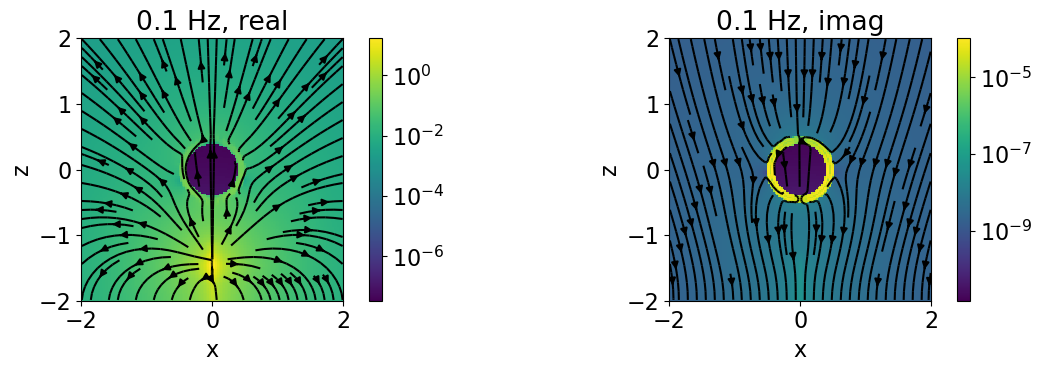

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

key = keys[0]
freq_ind = 0
xlim = 2*np.r_[-1, 1]
zlim = xlim

field_plot = (mesh.average_face_to_cell_vector * fields[key][sim.survey.source_list[freq_ind], "j"])

for i, component in enumerate(["real", "imag"]): 
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        # sample_grid = np.r_[10, 10],
        mirror=True, #mirror_data=field_mirror,
        ax=ax[i], 
        pcolor_opts={"norm":LogNorm()}
    )
    cb = plt.colorbar(out[0], ax=ax[i])
    # cb.set_label("Electric Field (V/m)")
    ax[i].set_aspect(1)
    ax[i].set_title(f"{frequencies[freq_ind]} Hz, {component}")
plt.tight_layout()

In [26]:
# def load_fields(name, conductivity, mur):
#     solution = np.load(f"{directory}/fields_{name}.npy")
#     sim = generate_simulation(mur)
#     sim.model = conductivity
#     f = sim.fieldsPair(sim)
#     f[:, sim._solutionType] = solution
#     return f

In [27]:
len(frequencies)

36

In [28]:
# casing_t_inv = np.r_[5e-3]
# mur_inv = np.r_[1, 50, 100, 150, 200]
# freq_inds_inv = np.arange(0, 31, 1)
# src_ind_inv = 5

# inv_keys = []
# for t in casing_t_inv:
#     for mur in mur_inv:
#         inv_keys.append(f"casing_{mur}_{t:1.2e}")
# inv_keys

In [29]:
# frequencies[freq_inds_inv]

In [30]:
# fields = {}
# for key in inv_keys:
#     # if key not in fields.keys():
#     fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

In [31]:
rcParams["font.size"] = 12

In [32]:
fields.keys()

dict_keys(['casing_sig5e+05_mur1', 'casing_sig1e+06_mur1', 'casing_sig5e+06_mur1', 'casing_sig1e+07_mur1'])

In [33]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [34]:
rx_x = np.linspace(1, 20, 19)
rx_z = -np.linspace(-15, 15, 21)
rx_z

array([ 15. ,  13.5,  12. ,  10.5,   9. ,   7.5,   6. ,   4.5,   3. ,
         1.5,  -0. ,  -1.5,  -3. ,  -4.5,  -6. ,  -7.5,  -9. , -10.5,
       -12. , -13.5, -15. ])

In [35]:
def create_receivers():
    rx_ex_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="real",
    )
    rx_ex_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="imag",
    )
    rx_ez_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="real",
    )
    rx_ez_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="z",
        component="imag",
    )
    return rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im

In [36]:
rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
Px = rx_ex_re.getP(mesh, "Fx")
Pz = rx_ez_re.getP(mesh, "Fz")

In [37]:
frequencies

array([1.00000000e-01, 1.38949549e-01, 1.93069773e-01, 2.68269580e-01,
       3.72759372e-01, 5.17947468e-01, 7.19685673e-01, 1.00000000e+00,
       1.38949549e+00, 1.93069773e+00, 2.68269580e+00, 3.72759372e+00,
       5.17947468e+00, 7.19685673e+00, 1.00000000e+01, 1.38949549e+01,
       1.93069773e+01, 2.68269580e+01, 3.72759372e+01, 5.17947468e+01,
       7.19685673e+01, 1.00000000e+02, 1.38949549e+02, 1.93069773e+02,
       2.68269580e+02, 3.72759372e+02, 5.17947468e+02, 7.19685673e+02,
       1.00000000e+03, 1.38949549e+03, 1.93069773e+03, 2.68269580e+03,
       3.72759372e+03, 5.17947468e+03, 7.19685673e+03, 1.00000000e+04])

In [38]:
range(len(frequencies))

range(0, 36)

In [39]:
# get data_vectors
dobs_dict = {}

for k in keys:
    tmp_dict = {}
    for si in range(len(frequencies)):
        src = sim.survey.source_list[si]
        e = fields[k][src, "e"]
        edatax = (Px * e).squeeze()
        edataz = (Pz * e).squeeze()
        tmp_dict[frequencies[si]] = {
            "real_x": edatax.real,
            "imag_x": edatax.imag,
            "real_z": edataz.real,
            "imag_z": edataz.imag
        }
    dobs_dict[k] = tmp_dict
        

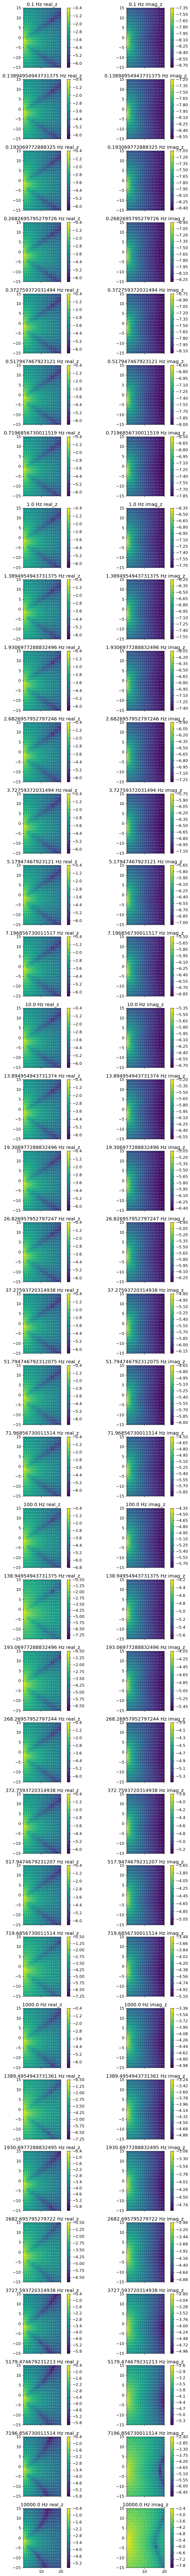

In [40]:
fig, ax = plt.subplots(len(frequencies), 2, figsize=(10, len(frequencies)*3), sharex=True)

key_ind = 0
key = keys[key_ind]

for i, freq in enumerate(frequencies): 
    # ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
    for j, component in enumerate(["real_z", "imag_z"]): 
        plt.colorbar(
            ax[i, j].contourf(
                rx_x, rx_z, np.log10(np.abs(dobs_dict[key][freq][component].reshape((len(rx_x), len(rx_z)), order="F").T)), 30,
                # vmin=-7, vmax=-2
                # norm=LogNorm()
            ), ax=ax[i, j]
        )
        
        ax[i, j].plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
        ax[i, j].set_aspect(1)
        ax[i, j].set_title(f"{freq} Hz {component}")

plt.tight_layout()


In [41]:
def get_amplitude_phase(real, imag):
    # real = f.real
    # imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

# set up mappings and simulation

In [42]:
def create_maps(key):
    inds_interior = (
        (mesh.cell_centers[:, 0]**2 + mesh.cell_centers[:, 2]**2) <= casing_b**2
    )

    active_inds_sigma = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=np.log(models[key]["sigma"][~inds_interior])
    )

    active_inds_mur = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=models[key]["mur"][~inds_interior]
    )

    projection_sigma = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])
    projection_mu = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])

    exp_map = maps.ExpMap(mesh)
    mur_map = maps.MuRelative(mesh)

    sigma_map = exp_map * active_inds_sigma * projection_sigma
    mu_map = mur_map * active_inds_mur * projection_mu

    return sigma_map, mu_map

In [43]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)
# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }
sigdc

sigma_map, mu_map = create_maps(keys[0])
np.unique(sigma_map*np.r_[np.log(sigdc[0])])

array([1.0e-01, 1.8e+05])

In [44]:
casing_b

0.5

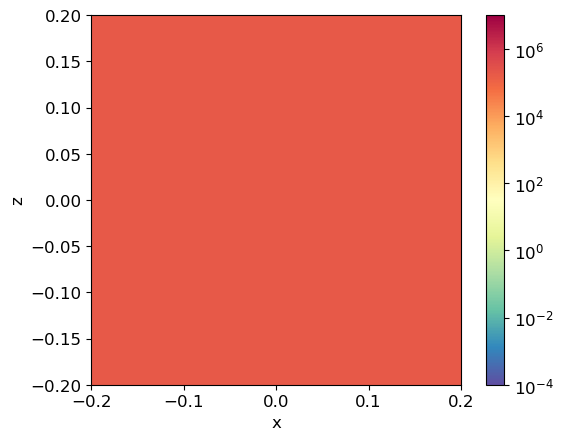

In [45]:
sigma_map, mu_map = create_maps(keys[0])

fig, ax = plt.subplots(1,1)

pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax), "cmap":"Spectral_r"}
out = mesh.plot_image(
    sigma_map*np.r_[np.log(sigdc[0])], pcolor_opts=pcolor_opts, ax=ax, mirror=True
)

plt.colorbar(out[-1], ax=ax)

xlim = 2*np.r_[-1, 1]
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_aspect(1)

In [46]:
def create_survey(freq, components=["x", "z"]): 
    rx_ex_re, rx_ex_im, rx_ez_re, rx_ez_im = create_receivers()
    rx_list = []
    if "x" in components: 
        rx_list.append([rx_ex_re, rx_ex_im])
    if "z" in components: 
        rx_list.append([rx_ez_re, rx_ez_im])
    src = fdem.sources.LineCurrent(list(np.hstack(rx_list)), location=src_locations, frequency=freq)
    return fdem.Survey([src])

In [47]:
# create the simulation
def create_simulation(key, survey, invert_mu=False):
    sigma_map, mu_map = create_maps(key)

    if invert_mu is True: 
        wires = maps.Wires(("sigma", 1), ("mu", 1))
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map * wires.sigma,
            muMap=mu_map * wires.mu 
        )
    else: 
        sim = fdem.simulation.Simulation3DMagneticField(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map
        )
    return sim


In [48]:
survey_tmp = create_survey(frequencies[0])
sim_tmp = create_simulation(keys[0], survey_tmp)

In [49]:
fields_tmp = sim_tmp.fields(np.r_[np.log(sigdc[0])])

In [50]:
fields_tmp[:, "j"]

array([[-3.40066324e-17+4.03400615e-18j],
       [-6.80132648e-17+8.06801230e-18j],
       [-1.02019897e-16+1.21020184e-17j],
       ...,
       [ 2.74159696e-12-1.31473250e-12j],
       [ 1.52598685e-12-8.68325036e-13j],
       [ 3.24210727e-13-2.24038532e-13j]])

In [51]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)

data0 = {}
res0 = {}
rms0 = {}

components = ["x", "z"]

for i, key in enumerate(keys): 
    data_tmp = {}
    res_tmp = {}
    rms_tmp = {}
    
    for freq in frequencies: 
        survey = create_survey(freq, components)
    
        receivers = []
        if "x" in components: 
            receivers.append(["real_x", "imag_x"])
        if "z" in components: 
            receivers.append(["real_z", "imag_z"])
        dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    
        sim = create_simulation(key, survey, invert_mu=False)
        dpred = sim.dpred(np.log(sigdc[i]))

        data_tmp[freq] = dpred
        res_tmp[freq] = dpred - dobsvec
        rms_tmp[freq] = np.sqrt(np.sum(res_tmp[freq]**2) / len(res_tmp[freq]))
    data0[key] = data_tmp
    res0[key] = res_tmp
    rms0[key] = rms_tmp

10.0


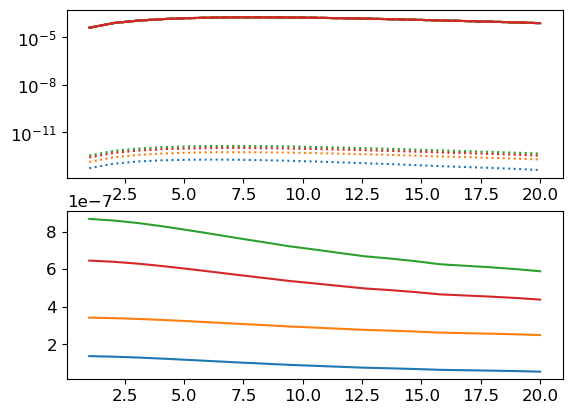

In [52]:
fig, ax = plt.subplots(2, 1)

freq = frequencies[14]
print(freq)
for i, key in enumerate(keys): 
    dobs = dobs_dict[key][freq]["real_x"][:len(rx_x)]
    d0 = data0[key][freq][:len(rx_x)]
    ax[0].semilogy(rx_x, np.abs(dobs), color=f"C{i}", label=key)
    ax[0].semilogy(rx_x, np.abs(d0), f"--C{i}")
    ax[0].semilogy(rx_x, np.abs(d0-dobs), f":C{i}")

    ax[1].plot(rx_x, np.abs(d0-dobs)/np.abs(dobs)*100, f"C{i}")

In [53]:
def create_misfit(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    true_casing_inds=False, components=["x", "z"]
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu)
    
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    return dmis
    # def dmis_func(x):
    #     f = sim.fields(x)
    #     return np.r_[dmis(x, f=f)], dmis.deriv(x, f=f)

    # return dmis_func  


In [54]:
misfit_dict = {}
relative_error = 0.000
noise_floor = 1e-9

for key in keys:
    if key not in misfit_dict: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = create_misfit(
                    key, freq, invert_mu=False, relative_error=relative_error, noise_floor=noise_floor,
                    components=["x", "z"]
                )
        misfit_dict[key] = tmp

In [55]:
logsigmas = np.linspace(11, 16, 40)
freqs = frequencies

In [56]:
%%time
objfctvals = {}

for key in keys[:1]:
    objfctvals_tmp = {}
    t0 = time.time()
    
    for freq in freqs:  
        phi = misfit_dict[key][freq]
        objfctvals_tmp[freq]  = np.hstack([phi(s) for s in logsigmas])
    
    print(f"{key} {time.time() - t0:1.2f} s")
    objfctvals[key] = objfctvals_tmp
    

casing_sig5e+05_mur1 60.83 s
CPU times: user 15min 23s, sys: 49.3 s, total: 16min 12s
Wall time: 1min


In [57]:
cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=frequencies.min(), vmax=frequencies.max())
scalar_map = colormap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

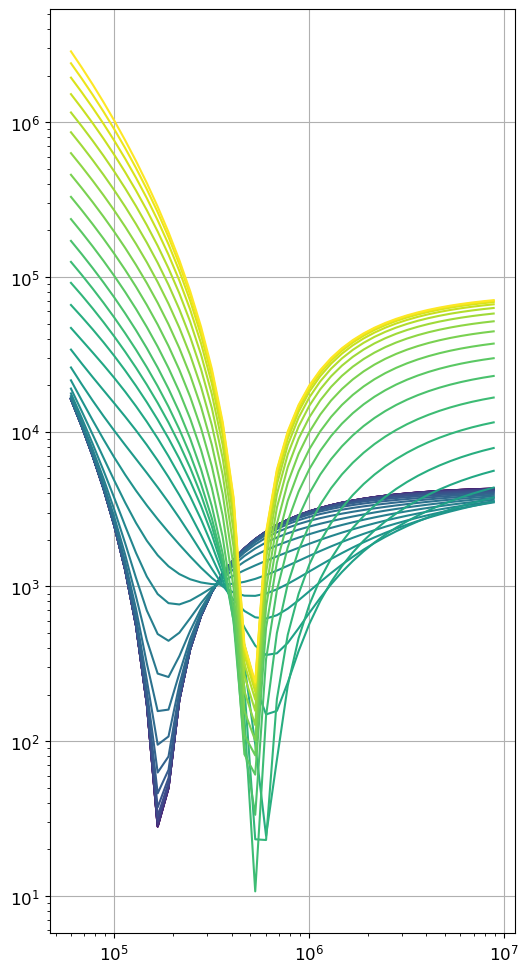

In [58]:
fig, ax = plt.subplots(len(keys[:1]), 1, figsize = (6, 3*len(keys)))

ax=np.atleast_1d(ax)

for i, k in enumerate(keys[:1]): 
    val = objfctvals[k]
    for j, f in enumerate(list(val.keys())):
        # if f < skin_depth_rhalf[i]:
        ax[i].loglog(np.exp(logsigmas), val[f], label=f"{f:1.2e} Hz", color=scalar_map.to_rgba(f))

        ind_min = val[f].argmin()
        # ax[i].loglog(np.exp(logsigmas[ind_min]), val[f][ind_min], ".k")

for i, a in enumerate(ax.flatten()):
    # a.vlines(sigdc[i], ymin=9e-1, ymax=1e6, color="k", lw=1)
    # a.vlines(sigma_casing[i], ymin=9e-1, ymax=1e6, color="k", lw=1)
    a.grid()
# a.set_xlim(6e4, 6e6)
# a.set_ylim(1e1, 1e4)
#     a.set_ylim(0, 1e3)
# ax.legend()

# set up inversions

In [59]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    results_file = None
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "phi_d":[],
            "dpred":[],
            "logsigma":[],
            "residual":[],
            "rms":[],
            # "mur":[]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        
        dobs = self.invProb._dmisfit.objfcts[0].data.dobs
        
        self.inversion_results["residual"].append((dobs - self.invProb.dpred))
        self.inversion_results["rms"].append(np.sqrt(np.sum(self.inversion_results["residual"][-1]**2)/len(dobs)))
        self.inversion_results["logsigma"].append(self.invProb.model[0])
        # self.inversion_results["mur"].append(self.invProb.model[0])
        
        if self.results_file is not None: 
            with open(f"{self.results_file}", "wb") as fp:
                pickle.dump(self.inversion_results, fp)
        
        

In [60]:
tmp = []
tmp.append(["a", "b"])
np.hstack(tmp)

array(['a', 'b'], dtype='<U1')

In [61]:
def create_inversion(
    key, freq, invert_mu=False, relative_error=None, noise_floor=None,
    maxIter=20, maxIterCG=20, maxIterLS=20, true_casing_inds=False, components=["x", "z"]
):
    # create the simulation
    survey = create_survey(freq, components)

    receivers = []
    if "x" in components: 
        receivers.append(["real_x", "imag_x"])
    if "z" in components: 
        receivers.append(["real_z", "imag_z"])
    dobsvec = np.hstack([dobs_dict[key][freq][rx] for rx in np.hstack(receivers)])
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(key, survey, invert_mu)
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    if invert_mu is True: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([2]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf, 1], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # aggressive_stepping=True
            # tolF=1e-3, tolX=1e-3,
        )
        # opt = optimization.InexactGaussNewton(
        #     maxIter=maxIter, #lower=np.r_[-np.inf, 1], 
        #     maxIterCG=maxIterCG, maxIterLS=maxIterLS,
        #     aggressive_stepping=True
        #     # tolF=1e-3, tolX=1e-3,
        # )
    else: 
        reg = regularization.Smallness(mesh=discretize.TensorMesh([1]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            # tolG=1e-6, eps=1e-8,
            # # # aggressive_stepping=True
            # tolF=1e-8, tolX=1e-3,
            # debug=True
        )
        # opt.stoppers = opt.stoppers[2:]
       #  opt = optimization.InexactGaussNewton(
       #      maxIter=maxIter, #lower=np.r_[-np.inf, 1], 
       #      maxIterCG=maxIterCG, maxIterLS=maxIterLS,
       #      tolG=1e-6, eps=1e-8,
       # #     aggressive_stepping=True
       #      tolF=1e-3, tolX=1e-3,
       #  )
        # opt = optimization.SteepestDescent(
        #     tolG=1e-6, tolF=1e-6, tolX=1e-6
        # )

    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

    # directives
    target_misfit = directives.TargetMisfit(chifact=1e-3)
    
    if true_casing_inds:
        filename_save = f"inv_{key}_{freq:1.0f}_true_casing.pkl"
    else: 
        filename_save = f"inv_{key}_{freq:1.0f}.pkl"
    inversion_progress = SaveInversionProgress(results_file=f"{directory_path}/{filename_save}")
    
    # inversion 
    inv = inversion.BaseInversion(inv_prob, [target_misfit, inversion_progress])
    
    return inv

In [62]:
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=np.r_[-np.inf], 
    maxIterCG=20, maxIterLS=10,
    # tolG=1e-6, eps=1e-8,
    # # aggressive_stepping=True
    # tolF=1e-8, tolX=1e-3,
)

In [63]:
# opt._stoppers

In [64]:
opt.stoppersLS

[{'str': '%d :    ft     = %1.4e <= alp*descent     = %1.4e',
  'left': <function simpeg.optimization.StoppingCriteria.<lambda>(M)>,
  'right': <function simpeg.optimization.StoppingCriteria.<lambda>(M)>,
  'stopType': 'optimal'},
 {'str': '%d : maxIterLS =     %3d    <= iterLS          =    %3d',
  'left': <function simpeg.optimization.StoppingCriteria.<lambda>(M)>,
  'right': <function simpeg.optimization.StoppingCriteria.<lambda>(M)>,
  'stopType': 'critical'}]

# experiment 2: invert for solid cylinder conductivity, permeability 

In [65]:
keys

['casing_sig5e+05_mur1',
 'casing_sig1e+06_mur1',
 'casing_sig5e+06_mur1',
 'casing_sig1e+07_mur1']

In [66]:
models.keys()

dict_keys(['casing_sig5e+05_mur1', 'casing_sig1e+06_mur1', 'casing_sig5e+06_mur1', 'casing_sig1e+07_mur1'])

In [67]:
inv_dict = {}
relative_error = 0.000
noise_floor = 1e-9

for key in keys:
    if key not in inv_dict: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = create_inversion(
                key, freq, invert_mu=False, relative_error=relative_error, noise_floor=noise_floor,
                components=["x", "z"]
            )
        inv_dict[key] = tmp

In [68]:
tmp = inv_dict[keys[0]][frequencies[0]]

In [69]:
dmis = tmp.invProb.dmisfit.objfcts[0]

In [70]:
tmp_objfct = np.hstack([dmis(s) for s in logsigmas])

In [71]:
tmp_g = np.hstack([dmis.deriv(s) for s in logsigmas])

In [72]:
# tmp_H = np.hstack([dmis.deriv2(s) for s in logsigmas])

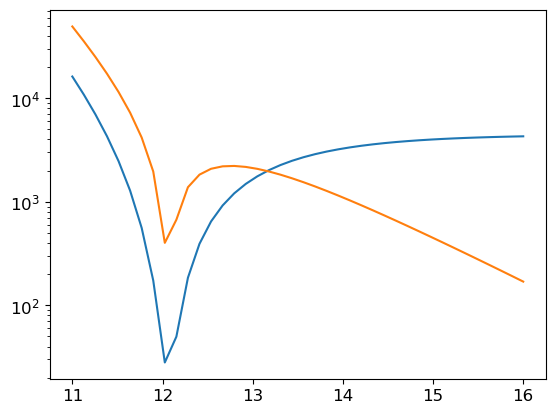

In [73]:
plt.semilogy(logsigmas, np.abs(tmp_objfct), label="f")
plt.semilogy(logsigmas, np.abs(tmp_g), label="g")

In [74]:
np.log(1e4)

9.210340371976184

In [75]:
t = casing_t
sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)
# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }
sigdc

array([ 180000.,  360000., 1800000., 3600000.])

In [76]:
mrec_dict = {}

for i, key in enumerate(keys):
    if key not in mrec_dict: 
        tmp = {}
        for freq in frequencies:
            print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")

            mstart = np.log(sigdc[i])
                
            tmp[freq] = inv_dict[key][freq].run(mstart) 
            print(f"recovered conductivity: {np.exp(inv_dict[key][freq].m[0]):1.2e} \n")
        mrec_dict[key] = tmp



------------------------ casing_sig5e+05_mur1 : 0.1 Hz -------------------------- 

simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DMagneticField problem***
                        
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  2.43e+01  0.00e+00  2.43e+01    2.77e+02      0              
   1  0.00e+00  1.97e+01  1.11e-03  1.97e+01    4.81e+00      0              
   2  0.00e+00  1.97e+01  1.07e-03  1.97e+01    1.23e-03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.2986e-03 <= tolF*(1+|f0|) = 2.5324

In [77]:
mrec_dict[keys[0]].values()

dict_values([array([12.06800172]), array([12.06800449]), array([12.06800985]), array([12.06802022]), array([12.06804026]), array([12.06807896]), array([12.06815371]), array([12.06829809]), array([12.06857718]), array([12.06911756]), array([12.07016598]), array([12.07221006]), array([12.07623171]), array([12.08423745]), array([12.10101997]), array([12.13863625]), array([12.24110343]), array([12.77468537]), array([13.12385426]), array([13.27424686]), array([13.3502602]), array([13.35821982]), array([13.31406936]), array([13.24267284]), array([13.17504436]), array([13.13354703]), array([13.11933731]), array([13.11910669]), array([13.12121661]), array([13.12210475]), array([13.12221843]), array([13.12211592]), array([13.12191512]), array([13.12162482]), array([13.12128658]), array([13.1209689])])

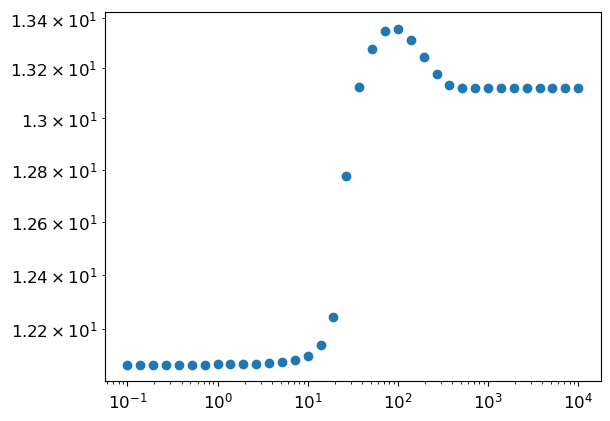

In [78]:
fig, ax = plt.subplots(1, 1)
for key in keys[:1]: 
    ax.loglog(frequencies, mrec_dict[key].values(), "o", label=key)

In [79]:
inv_results = {}

for key in keys:
    if key not in inv_results: 
        tmp = {}
        for freq in frequencies:
            tmp[freq] = inv_dict[key][freq].directiveList.dList[1].inversion_results
        inv_results[key] = tmp

In [80]:
tmp = inv_results[keys[0]][frequencies[0]]

In [81]:
tmp = inv_dict[keys[0]][frequencies[0]]

In [82]:
phi_d_final = {}
chifact_final = {}
phid_star = len(rx_x)*len(rx_z)*2

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            phid_tmp[i] = phid[-1]
    phi_d_final[key] = phid_tmp
    chifact_final[key] = phi_d_final[key] / phid_star

In [83]:
phid_min = {}
chifact_min = {}
mrec_min = {}
rms_min = {}

for key in keys:
    phid_tmp = np.ones(len(frequencies)) * np.nan
    mrec_tmp = np.ones(len(frequencies)) * np.nan
    rms_tmp = np.ones(len(frequencies)) * np.nan
    for i, freq in enumerate(frequencies): 
        phid = inv_results[key][freq]["phi_d"]
        if len(phid) > 0: 
            ind_min = np.argmin(phid)
            phid_tmp[i] = phid[ind_min]
            mrec_tmp[i] = inv_results[key][freq]["logsigma"][ind_min]
            rms_tmp[i] = inv_results[key][freq]["rms"][ind_min]
    phid_min[key] = phid_tmp
    mrec_min[key] = mrec_tmp
    rms_min[key] = rms_tmp

In [84]:
dpred_rec = {}
std_dict = {}

nlocs = len(rx_x)*len(rx_z)

for key in keys:
    tmp_dpred = {}
    tmp_std = {}
    for i, freq in enumerate(frequencies):
        dpred = inv_dict[key][freq].invProb.dpred
        std = inv_dict[key][freq].invProb.dmisfit.objfcts[0].data.standard_deviation
        
        tmp_dpred[freq] = {
            "real_x":dpred[:nlocs],
            "imag_x":dpred[nlocs:2*nlocs],
            "real_z":dpred[2*nlocs:3*nlocs],
            "imag_z":dpred[3*nlocs:]
        }

        tmp_std[freq] = {
            "real_x":std[:nlocs],
            "imag_x":std[nlocs:2*nlocs],
            "real_z":std[2*nlocs:3*nlocs],
            "imag_z":std[3*nlocs:]
        }
        
    dpred_rec[key] = tmp_dpred
    std_dict[key] = tmp_std

In [85]:
inv_dict[key][freq].invProb.dmisfit.objfcts[0].simulation.sigmaMap * np.r_[12]

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [86]:
fields_rec = {}

for key in keys:
    tmp_fields = {}
    for i, freq in enumerate(frequencies):
        tmp_fields[freq] = inv_dict[key][freq].invProb.dmisfit.objfcts[0].simulation.fields(mrec_min[key][i])
 
    fields_rec[key] = tmp_fields

In [87]:
inv_dict[key][freq].invProb.dmisfit.objfcts[0].simulation.sigmaMap * np.r_[12]

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [88]:
inv_dict[key][freq].invProb.dmisfit.objfcts[0].simulation.fields(mrec_dict[keys[0]][frequencies[0]])[:, "j"]

array([[ 1.40778050e-40+3.82838876e-42j],
       [ 2.81556059e-40+7.65679340e-42j],
       [ 4.22333987e-40+1.14852298e-41j],
       ...,
       [ 4.54386815e-54+8.04446661e-54j],
       [ 2.19542617e-57-1.36385821e-57j],
       [-1.66043969e-61-2.54581863e-61j]])

In [89]:
mrec_dict[keys[0]][frequencies[0]]

array([12.06800172])

In [90]:
phi_d_final[keys[0]]

array([1.97193681e+01, 1.97417180e+01, 1.97848391e+01, 1.98681091e+01,
       2.00288754e+01, 2.03392467e+01, 2.09383584e+01, 2.20947330e+01,
       2.43260533e+01, 2.86293514e+01, 3.69198708e+01, 5.28598198e+01,
       8.33856747e+01, 1.41381847e+02, 2.49768466e+02, 4.44957597e+02,
       7.62031836e+02, 1.02945369e+03, 8.66391387e+02, 6.19157333e+02,
       3.57479624e+02, 1.42424671e+02, 2.43233717e+01, 4.92029284e-01,
       1.05531637e+01, 8.90571018e+00, 2.16787856e+00, 1.24519631e-01,
       5.03401056e-04, 1.40802849e-03, 1.01953133e-03, 3.69906515e-03,
       1.35220263e-02, 3.96391891e-02, 8.82942449e-02, 1.52011026e-01])

/tmp/ipykernel_2643827/2566683216.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ax[1].loglog(frequencies, np.exp(np.hstack(mrec_dict[key].values())), "o", label=key)


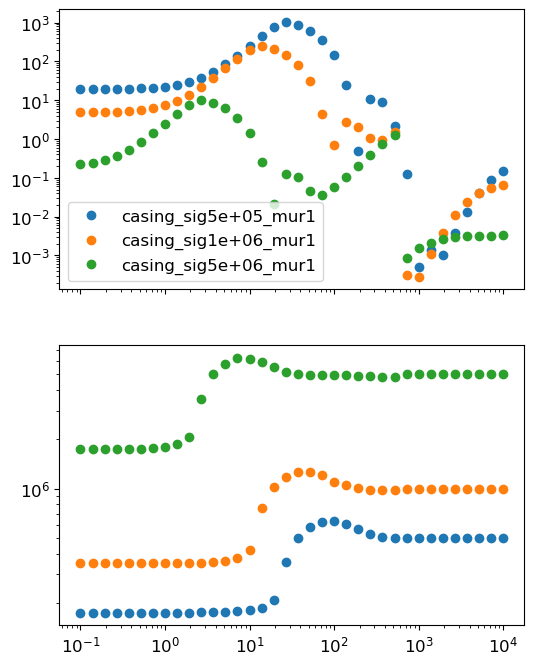

In [108]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True) 

for key in keys[:-1]: 
    ax[0].loglog(frequencies, phi_d_final[key], "o", label=key)
    # ax[0].semilogx(frequencies, phid_star * np.ones_like(frequencies),"--k")
    ax[1].loglog(frequencies, np.exp(np.hstack(mrec_dict[key].values())), "o", label=key)
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigma_casing, "--k")
    # ax[1].loglog(frequencies, np.ones_like(frequencies)*sigdc, "--k")
ax[0].legend()

<!-- 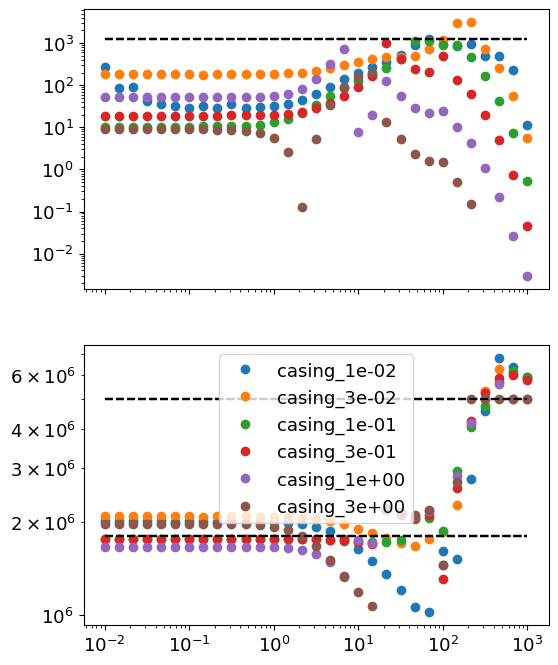 -->

In [92]:
markers = ["s", "v", "o", "D", "p", "D", "h"]
colors = ["C5", "C6", "k", "C9"]

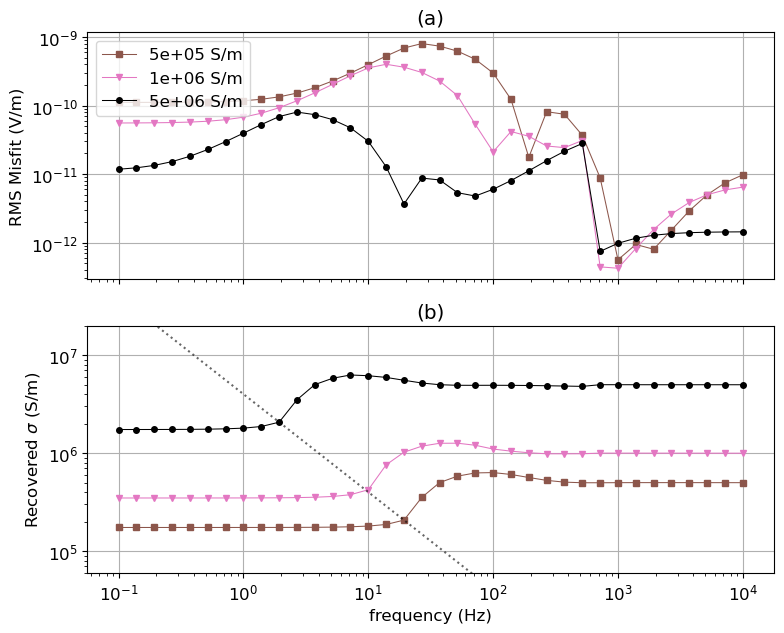

In [105]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6.5), sharex=True) #, dpi=dpi_high) 

for i, key in enumerate(keys[:-1]): 
    label = f"{sigma_casing[i]:1.0e} S/m"
    ax[0].loglog(frequencies, rms_min[key], f"-{markers[i]}", color=colors[i], lw=0.75, ms=4, label=label)
    ax[1].loglog(frequencies, np.exp(mrec_min[key]), f"-{markers[i]}", color=colors[i], lw=0.75, ms=4, label=label)
    # ax[1].loglog(frequencies, sigdc[i+1]*np.ones_like(frequencies), "--", color=colors[i], alpha=0.5)
    # ax[1].loglog(frequencies, sigma_casing[i+1]*np.ones_like(frequencies), "--", color=colors[i], alpha=0.5)
    # sig_t = 500**2 / (casing_t**2 * frequencies)
    # ax[1].loglog(frequencies, sig_t, ":k", alpha=0.2)

sig_b = 500**2 / ((casing_b/2)**2 * frequencies)
ax[1].loglog(frequencies, sig_b, ":k", alpha=0.6)

# ax[1].text(4e1, 1.2e7, "$\delta\sim r/2$", alpha=0.7)
# ax[1].text(2.3e2, 1.2e7, "$\delta\sim t$", alpha=0.7)
ax[0].legend(loc=2)

ax[0].set_ylabel("RMS Misfit (V/m)")
ax[1].set_ylabel("Recovered $\sigma$ (S/m)")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylim(6e4, 2e7)

ax[0].set_title("(a)")
ax[1].set_title("(b)")
for a in ax:
    a.grid()

plt.tight_layout()
    

<!-- 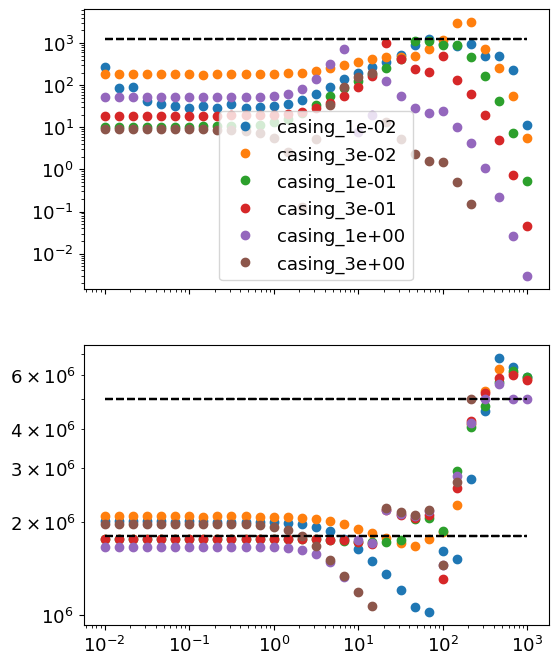 -->

In [94]:
# plot the data

In [95]:
def plot_data(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)

    plt.colorbar(
        ax.contourf(
            rx_x, rx_z, data.reshape((len(rx_x), len(rx_z)), order="F").T, 30
        ),
        ax=ax
    )

    ax.plot(rx_ex_re.locations[:, 0], rx_ex_re.locations[:, 2], "w.", ms=1)
    ax.set_aspect(1)

    return ax

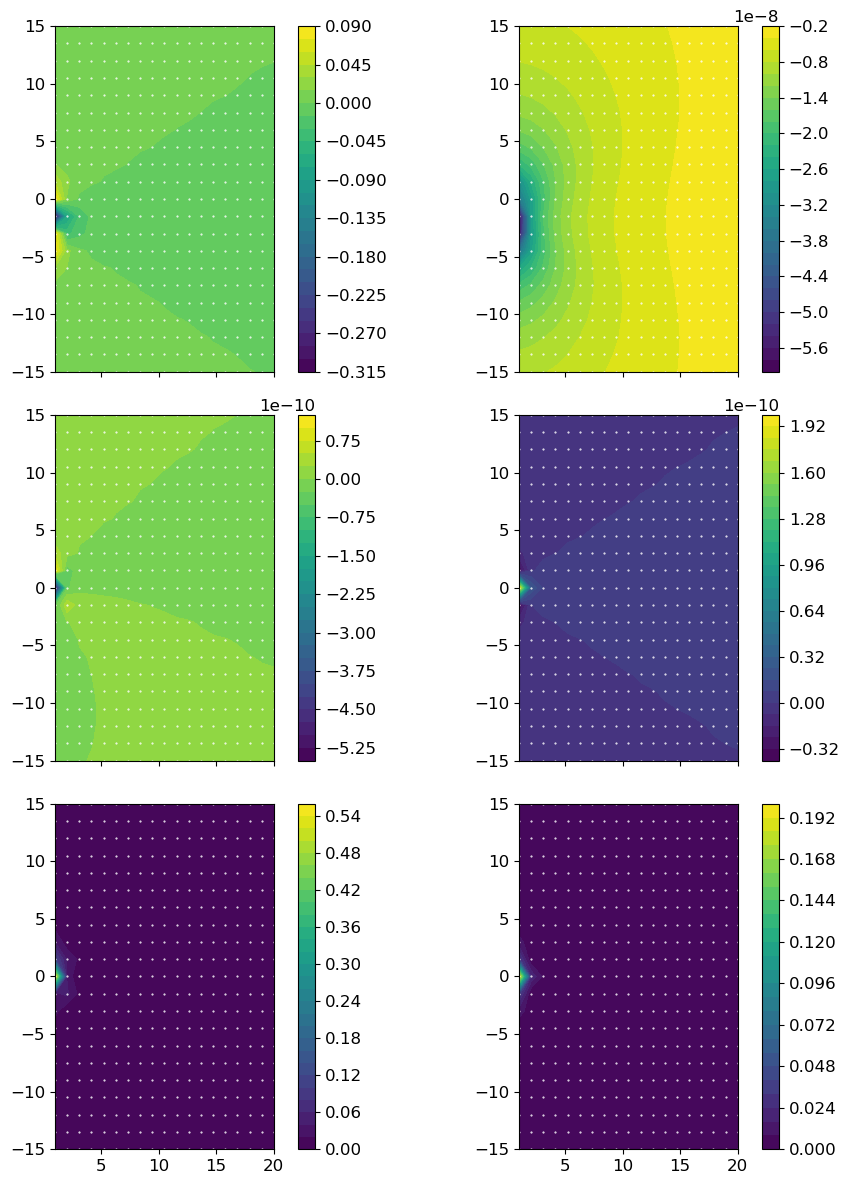

In [96]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharex=True)

key_ind = 1
key = keys[key_ind]

freq = frequencies[1]
 
# ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
for j, component in enumerate(["real_z", "imag_z"]): 
    pred = dpred_rec[key][freq][component]
    plot_data(pred, ax[0, j])
    
    diff = pred - dobs_dict[key][freq][component]
    plot_data(diff, ax[1, j])

    normalized_diff = np.abs(diff) / std_dict[key][freq][component] 
    plot_data(normalized_diff, ax[2, j])
    
    # ax[i, j].set_title(f"{freq} Hz {component}")

# for a in ax.flatten():
    # a.set_xlim(0, 600)
plt.tight_layout()


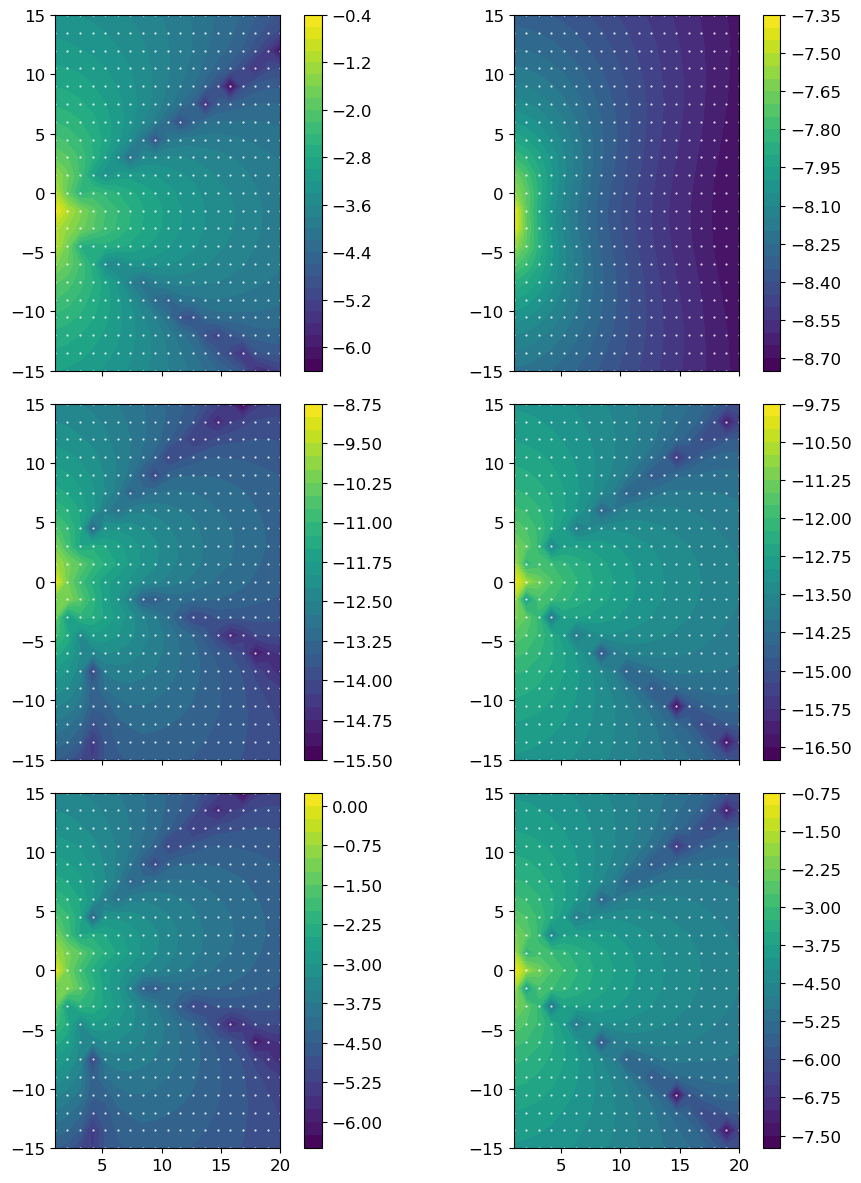

In [97]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12), sharex=True)

key_ind = 0
key = keys[key_ind]

freq = frequencies[0]
 
# ax.plot(rx_x, dobs_dict[key][freq]["real"].reshape((len(rx_x), len(rx_z)), order="F"), "o" );
for j, component in enumerate(["real_z", "imag_z"]): 
    pred = dpred_rec[key][freq][component]
    plot_data(np.log10(np.abs(pred)), ax[0, j])
    
    diff = pred - dobs_dict[key][freq][component]
    plot_data(np.log10(np.abs(diff)), ax[1, j])

    normalized_diff = np.abs(diff) / std_dict[key][freq][component] 
    plot_data(np.log10(np.abs(normalized_diff)), ax[2, j])
    
    # ax[i, j].set_title(f"{freq} Hz {component}")

plt.tight_layout()


In [98]:
def plot_fields(
    field_plot, freq_ind=0, xlim=500*np.r_[-1, 1], zlim=np.r_[-1000, 10], component="real", ax=None, vmin=None, vmax=None, aspect=True,
    plot_source=False
):
    if ax is None: 
        fig, ax = plt.subplots(1,1)

    field_plot = mesh.average_face_to_cell_vector * np.squeeze(field_plot)
    
    out = mesh.plot_image(
        getattr(field_plot, component), "CCv", view="vec", 
        range_x = xlim, range_y = zlim,
        sample_grid = np.r_[np.diff(xlim)/100, np.diff(zlim)/100],
        mirror=True, #mirror_data=field_mirror,
        ax=ax, 
        pcolor_opts={"norm":LogNorm(vmin=vmin, vmax=vmax)},
        stream_threshold=vmin
    )

    if plot_source is True: 
        ax.plot(src_locations[:, 0], src_locations[:, 2], "w", lw=2)
    
    cb = plt.colorbar(out[0], ax=ax)
    # cb.set_label("Electric Field (V/m)")
    if aspect is True:
        ax.set_aspect(1)

    return out, cb

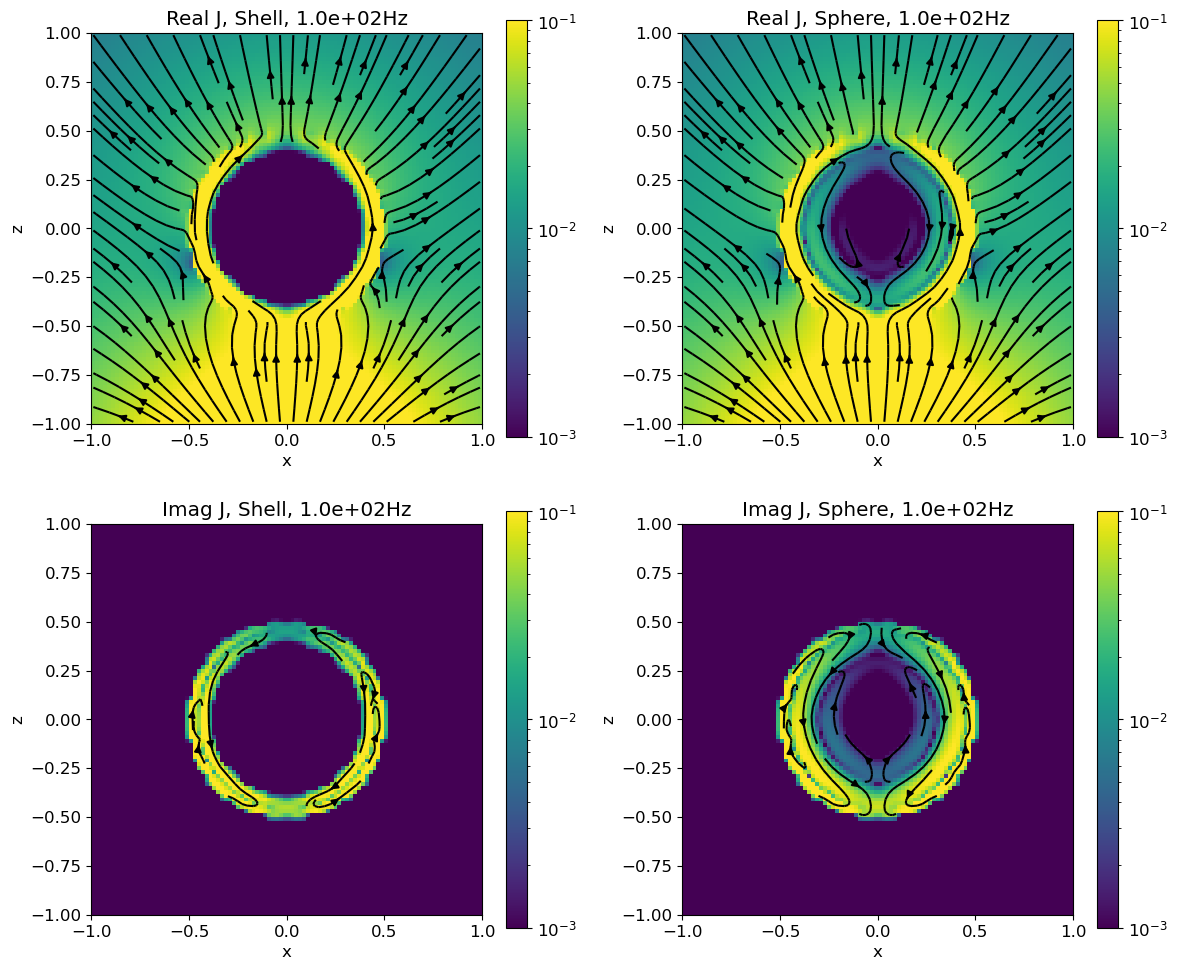

In [122]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

key = keys[1]
freq_ind = 21

aspect = False
xlim = 1*np.r_[-1, 1]
zlim = xlim #np.r_[-550, 0] 
plot_source = True
vmin=1e-3
vmax=1e-1

true_fields = fields[key]
fields_true = true_fields[true_fields.simulation.survey.source_list[freq_ind], "j"]
plot_fields(
    fields_true, component="real", ax=ax[0, 0], aspect=aspect,
    xlim=xlim, zlim=zlim, plot_source=plot_source, vmin=vmin, vmax=vmax
)
plot_fields(
    fields_true, component="imag", ax=ax[1, 0], aspect=aspect, 
    xlim=xlim, zlim=zlim, plot_source=plot_source, vmin=vmin, vmax=vmax
)
ax[0, 0].set_title(f"Real J, Shell, {frequencies[freq_ind]:1.1e}Hz")
ax[1, 0].set_title(f"Imag J, Shell, {frequencies[freq_ind]:1.1e}Hz")

fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]

fields_diff = fields_true - fields_pred
plot_fields(
    fields_pred, component="real", ax=ax[0, 1], vmin=vmin, aspect=aspect, 
    xlim=xlim, zlim=zlim, plot_source=plot_source, vmax=vmax
)
plot_fields(
    fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, aspect=aspect, 
    xlim=xlim, zlim=zlim, plot_source=plot_source, vmax=vmax
)
ax[0, 1].set_title(f"Real J, Sphere, {frequencies[freq_ind]:1.1e}Hz")
ax[1, 1].set_title(f"Imag J, Sphere, {frequencies[freq_ind]:1.1e}Hz")

for a in ax.flatten():
    a.set_aspect(1)

plt.tight_layout()

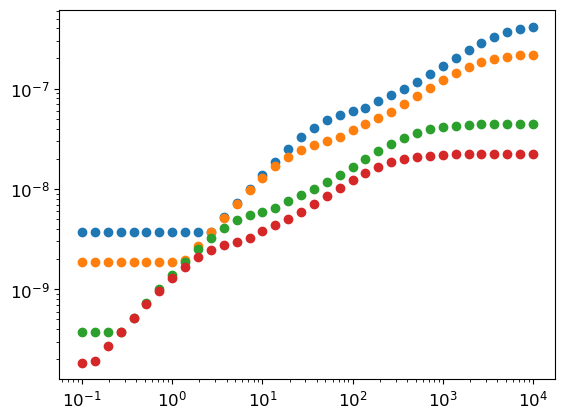

In [123]:
fig, ax = plt.subplots(1, 1) 
for key in keys: 
    max_diff = np.hstack([np.max(np.abs(res0[key][f]))for f in frequencies])
    ax.loglog(frequencies, max_diff, "o", label=key)

In [101]:
500/np.sqrt(sigma_casing * 2) 

array([0.5       , 0.35355339, 0.15811388, 0.1118034 ])

In [102]:
casing_t

0.1

NameError: name 'csz' is not defined

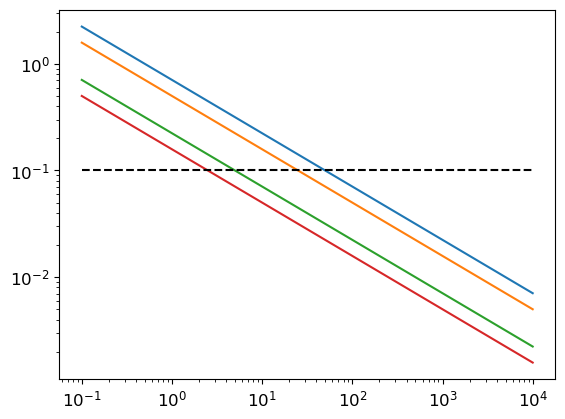

In [103]:
skin_depths_casing = 500/np.sqrt(np.outer(sigma_casing,frequencies)).T

fig, ax = plt.subplots(1, 1) 
ax.loglog(frequencies, skin_depths_casing)
ax.loglog(frequencies, np.ones_like(frequencies)*casing_t, "--k")
ax.loglog(frequencies, np.ones_like(frequencies)*csz, ":k")

In [ ]:
x_data = mesh.nodes_x[31]
data_locs = np.hstack([mesh.faces_x[:, 0] == x_data, np.zeros(mesh.n_faces_z, dtype=bool)])
np.sum(data_locs)

In [ ]:
frequencies[14]

In [ ]:
keys

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 10), sharey=True)

key = keys[2]
freq_ind = 27

aspect = False
xlim = 0.08*np.r_[0, 1]
zlim = np.r_[-550, 0] 
plot_source = True
vmin=1e-8
vmax=1e1

true_fields = fields[key]
fields_true = true_fields[true_fields.simulation.survey.source_list[freq_ind], "j"]
plot_fields(fields_true, component="real", ax=ax[0, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_true, component="imag", ax=ax[1, 0], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
ax[0, 0].set_title("Real, Hollow")
ax[1, 0].set_title("Imag, Hollow")


fields_pred = fields_rec[key][frequencies[freq_ind]][:, "j"]
plot_fields(fields_pred, component="real", ax=ax[0, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
plot_fields(fields_pred, component="imag", ax=ax[1, 1], vmin=vmin, vmax=vmax, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
ax[0, 1].set_title("Real, Solid")
ax[1, 1].set_title("Imag, Solid")

for i, component in enumerate(["real", "imag"]):
    ax[i, 2].semilogx(np.abs(getattr(fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="hollow")
    ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="solid")
    ax[i, 2].semilogx(np.abs(getattr(fields_pred[data_locs] - fields_true[data_locs], component)), mesh.cell_centers_z, ".", ms=3, label="diff")
    ax[i, 2].set_ylim(zlim)
    ax[i, 2].set_xlim(np.r_[vmin, vmax*1e-2])
    ax[i, 2].grid()
    ax[i, 2].set_title(f"j$_x$ {component} at {x_data:1.2f}m")
    ax[i, 2].set_xlabel("j$_x$ (A/m$^2$)")

ax[0, 2].legend(loc=1)
fig.suptitle(f"{key.split('_')[1][3:]}S/m, {key.split('_')[-1][3:]} $\mu_0$, {frequencies[freq_ind]:1.1e} Hz, rms: {rms_min[key][freq_ind]:1.1e} V/m")

# fields_diff = fields_true - fields_pred
# plot_fields(fields_diff, component="real", ax=ax[0, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)
# plot_fields(fields_diff, component="imag", ax=ax[1, 1], vmin=vmin, aspect=aspect, xlim=xlim, zlim=zlim, plot_source=plot_source)


plt.tight_layout()

In [ ]:
# key = "casing_1_1.00e-02"
# freq = frequencies[freq_inds_inv[0]]

# plot_obs_pred(key, freq, False);